# Average Daily Temperatures in Utah (Mountain Weather) (2010-2019)
**[NOAA](https://data.noaa.gov/dataset/dataset/global-surface-summary-of-the-day-gsod) Global Surface Summary of the Day**

## Step 1: Import Python modules and define helper functions

In [ ]:
!pip install basemap

  Obtaining dependency information for basemap from https://files.pythonhosted.org/packages/13/c8/b10d328a626d8cbb5d64f56aa7dde148c302f44cd1dd75f2af900f80478c/basemap-1.3.8-cp310-cp310-manylinux1_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 37.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.7/860.7 kB 46.2 MB/s eta 0:00:00


In [ ]:
!pip install chart-studio

In [ ]:
!pip install pycountry

  Obtaining dependency information for pycountry from https://files.pythonhosted.org/packages/48/12/fdbcd29b5a243af2f1c1a83636a21e3837aeaa070c9212ebe657e39ce563/pycountry-23.12.11-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 40.3 MB/s eta 0:00:0000:0100:01


In [ ]:
from mpl_toolkits.basemap import Basemap
import folium
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import pycountry
import datetime
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
import bq_helper
from bq_helper import BigQueryHelper
helper = BigQueryHelper('bigquery-public-data', 'noaa_gsod')

def plotPointsOnMap(dataframe,beginIndex,endIndex,latitudeColumn,latitudeValue,longitudeColumn,longitudeValue,zoom):
    df = dataframe[beginIndex:endIndex]
    location = [latitudeValue,longitudeValue]
    plot = folium.Map(location=location,zoom_start=zoom)
    for i in range(0,len(df)):
        popup = folium.Popup(str(df.name[i:i+1]))
        folium.Marker([df[latitudeColumn].iloc[i],df[longitudeColumn].iloc[i]],popup=popup).add_to(plot)
    return(plot)

def color_coded_map(df, center_lat, center_lon, zoom):
    # Adapted from  https://www.kaggle.com/dejavu23/openaq-from-queries-to-world-maps
    m = folium.Map(location=[center_lat, center_lon],
                   zoom_start = zoom)
    for index, row in df.iterrows():
        folium.CircleMarker( [row['lat'], row['lon']] , radius=10,
                             color=custom_colormap(row['avg_temp']),
                             fill=True, fill_opacity=1.0,
                             fill_color=custom_colormap(row['avg_temp']),
                             popup=row['name'] ).add_to(m)
    custom_colormap.add_to(m)
    folium.TileLayer(tiles='Stamen Toner',name="Stamen Toner", attr='Your attribution').add_to(m)
    folium.TileLayer(tiles='Stamen Terrain',name="Stamen Terrain", attr='Your attribution').add_to(m)
    folium.TileLayer(tiles='cartodbpositron',name="cartodbpositron", attr='Your attribution').add_to(m)
    folium.LayerControl().add_to(m)
    return m

def mapAvgTemperature(df,latitude,longitude):
    # adapted from https://www.kaggle.com/anhuang/visualization-of-global-climatic-change
    df_ = df#.sample(5000)
    m = Basemap(projection='aea',lat_0=latitude, lon_0=longitude, resolution='l', area_thresh=1,rsphere=1,height=1, width=1)# projection='cyl'
    m.drawmapboundary()
    m.drawcoastlines()
    parallels = np.arange(-90.,90,30.)
    m.drawparallels(parallels,labels=[False,True,True,False])
    meridians = np.arange(0.,350.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True])
    lon = df_['lon'].tolist()
    lat = df_['lat'].tolist()
    df_['avg_temp'] = df_['avg_temp'].astype(int)
    temp = df_['avg_temp'].tolist()
    xpt,ypt = m(lon,lat)
    cm = plt.cm.get_cmap('jet')
    m.scatter(xpt, ypt, c=temp, cmap=cm, vmin = -70, vmax=100, s = 10, alpha = 0.4)
    plt.gcf().set_size_inches(18.5, 10.5)
    plt.colorbar()
    plt.show()

def displayTemperaturePlots(weatherData):
    # Adapted from # https://www.kaggle.com/tanatiem/eda-bangkok-weather
    plt.style.use('bmh')
    # Plot #1
    # melt to display
    data = pd.melt(weatherData, 'year', ['temp','min','max'],
                   var_name='variable', value_name='degree')
    # Avg, Min, Max temp. boxplot
    ax = sns.boxplot(x='year',y='degree',hue='variable', hue_order=['min','temp','max'],
               data=data)
    ax.set_ylabel('Degree Fahrenheit')
    plt.show()
    # Plot #2
    # for labeling
    months = ['Jan','Feb','Mar','Apr','May','Jun',
              'Jul','Aug','Sep','Oct','Nov','Dec']
    data = weatherData.groupby(['mo'], as_index=False)[['temp','min','max']].mean()
    ax = data[['temp','min','max']].plot();
    ax.set_ylabel('Temperature (F)')
    ax.set_xlabel('Month')
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(months)
    ax.set_title('Average Daily Temperature by Month');
    plt.show()
    # Plot #3
    month_df = weatherData.groupby(['year','mo'], as_index=False)[['temp']].mean()
    # Temperature heatmap
    data = month_df.pivot(index = 'year',columns = 'mo',values = 'temp')
    data.columns = months
    sns.heatmap(data, cmap='YlOrRd',annot=True, fmt='.1f', vmin=27)
    plt.title('Average Daily Temperature (F) by Month')
    plt.yticks(rotation=0)
    plt.show()

def cleanWeatherData(dataframe):
    # Adapted from # https://www.kaggle.com/tanatiem/eda-bangkok-weather
    weather=dataframe
    weather['temp'] = weather['temp'].replace({ 9999.9 : np.nan })
    weather['min'] = weather['min'].replace({ 9999.9 : np.nan })
    weather['max'] = weather['max'].replace({ 9999.9 : np.nan })
    weather['date'] = weather.apply(lambda x:datetime.datetime(int(x.year), int(x.mo), int(x.da)),axis=1)
    weather = weather.set_index('date')
    start_date = '{}010101'.format(years[0]) #0101
    end_date = weather.index.max().strftime('%Y%m%d')
    missing = weather[weather.isnull().any(axis=1)].index
    weather = weather.interpolate()
    weather['year'] = weather.index.year
    weather['mo'] = weather.index.month
    weather['da'] = weather.index.day
    data = weather[['temp','min','max']]
    data.reset_index(inplace=True)
    data.columns = ['Date','Avg Temp', 'Min Temp', 'Max Temp']
    return(data)

Using Kaggle's public dataset BigQuery integration.


## Step 2: Write queries for average daily temperature in USA and Utah

In [ ]:
avgTemps = '''
SELECT
    stn, avg_temp, lat,lon, name
FROM(
    SELECT stn,AVG(data.temp) AS avg_temp
    FROM `bigquery-public-data.noaa_gsod.gsod2019` AS data
    GROUP BY stn) temp_
INNER JOIN
    `bigquery-public-data.noaa_gsod.stations`AS stations
ON
    temp_.stn = stations.usaf
'''

tempsAtStationName = '''
SELECT
    year, mo, da, temp, min, max
FROM
    `bigquery-public-data.noaa_gsod.gsod{}` a
    INNER JOIN `bigquery-public-data.noaa_gsod.stations` b ON a.stn = b.usaf
WHERE
    country = 'US' AND name = '{}'
'''
years = range(2010, 2020)
SLCWeather = [helper.query_to_pandas(tempsAtStationName.format(i, "SALT LAKE CITY INTERNATIONAL")) for i in years]
SLCWeather = pd.concat(SLCWeather)
cleanSLCWeather = cleanWeatherData(SLCWeather)
mountainWeather = [helper.query_to_pandas(tempsAtStationName.format(i, "BRYCE CANYON AIRPORT")) for i in years]
mountainWeather = pd.concat(mountainWeather)
cleanMountainWeather = cleanWeatherData(mountainWeather)

avgTemps = helper.query_to_pandas_safe(avgTemps)
avgTemps = avgTemps.dropna(axis=0)

lat= 39
lon= -111
ut_latitudeLower = avgTemps['lat'] > lat-3
ut_latitudeUpper = avgTemps['lat'] < lat+3
ut_longitudeLower = avgTemps['lon'] > lon-3
ut_longitudeUpper = avgTemps['lon'] < lon+3
ut_only = avgTemps[ut_latitudeLower & ut_latitudeUpper & ut_longitudeLower & ut_longitudeUpper]
ut_only.head(10)

,stn,avg_temp,lat,lon,name
1335,720531,53.883721,38.783,-108.067,BLAKE FIELD AIRPORT
1404,725753,55.764881,41.050,-113.070,EAGLE RANGE
1439,740030,53.486385,40.167,-112.933,DUGWAY PROVING GROU
1440,740030,53.486385,40.183,-112.933,MICHAEL AAF AIRPORT
1875,999999,52.986059,41.050,-113.060,EAGLE RANGE WSO
1880,999999,52.986059,39.102,-108.735,GRAND JUNCTION 9 W
1885,999999,52.986059,37.517,-111.978,TROPIC 9 SE
1900,999999,52.986059,39.761,-108.127,RIFLE 23 NW
1949,999999,52.986059,40.482,-111.429,HEBER CITY MUNI ARPT-RUSS MCD
1950,999999,52.986059,40.282,-111.240,PROVO 22 E


#### The above table shows the average temperatures for a range of stations in Utah.

## Step 3: Map of average daily temperature in the USA in 2019  (degrees Fahrenheit)

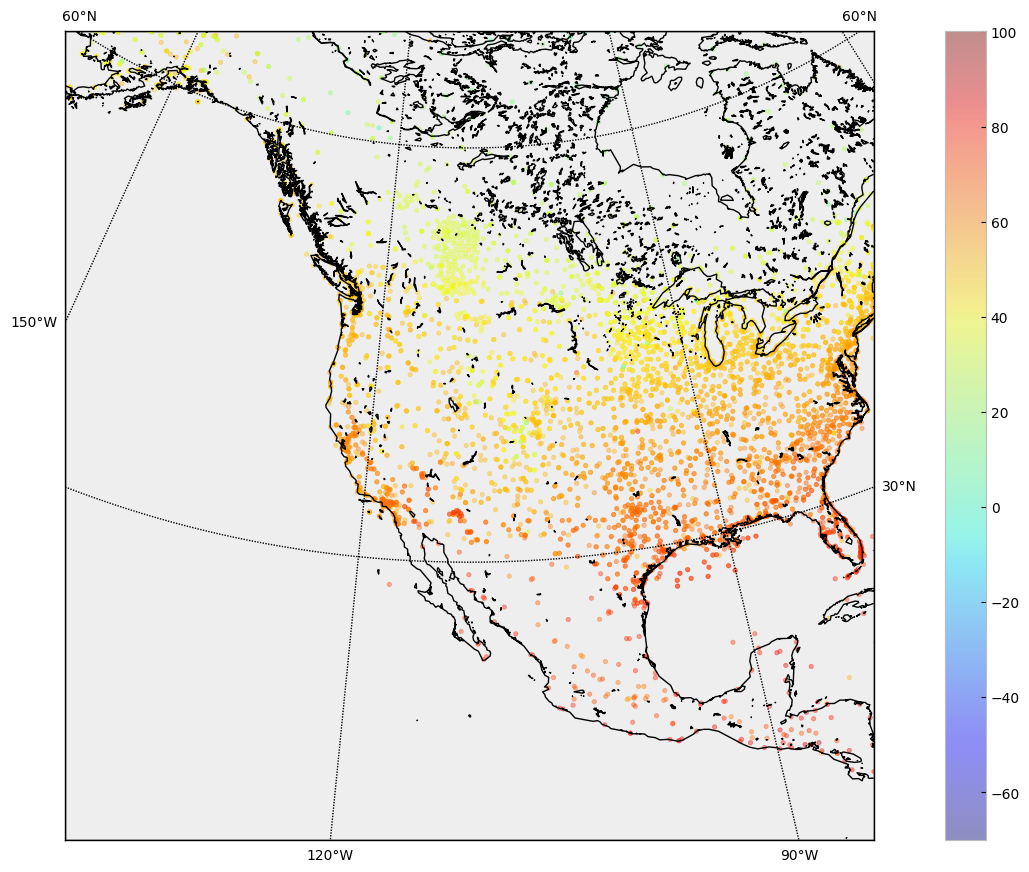

In [ ]:
mapAvgTemperature(avgTemps,39,-111)

## Step 4: Map average daily temperature in Utah in 2019  (degrees Fahrenheit)

In [ ]:
custom_colormap = \
    folium.StepColormap( ['purple','blue','green','yellow','orange','red'],
                         vmin=0, vmax=100,
                         index=[0,20,40,60,80,100],
                        caption='Degrees Fahrenheit')

temperature_map = color_coded_map(ut_only, 39,-111, 5)
temperature_map

## Step 5: Plot temperatures in Utah (2010-2019, degrees Fahrenheit)

SALT LAKE CITY INTERNATIONAL :



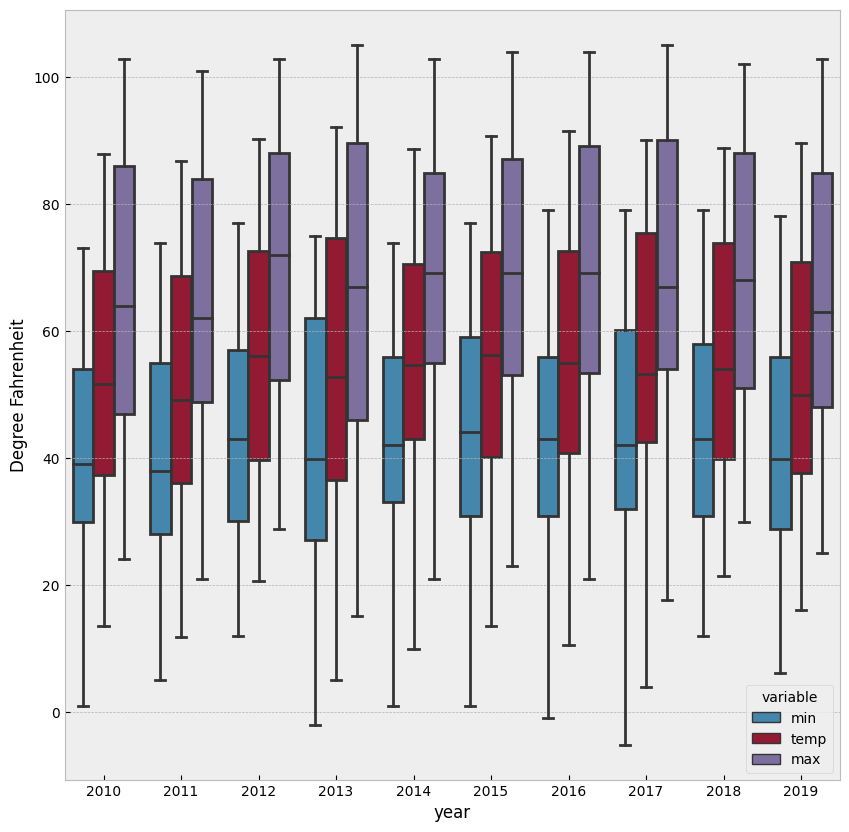

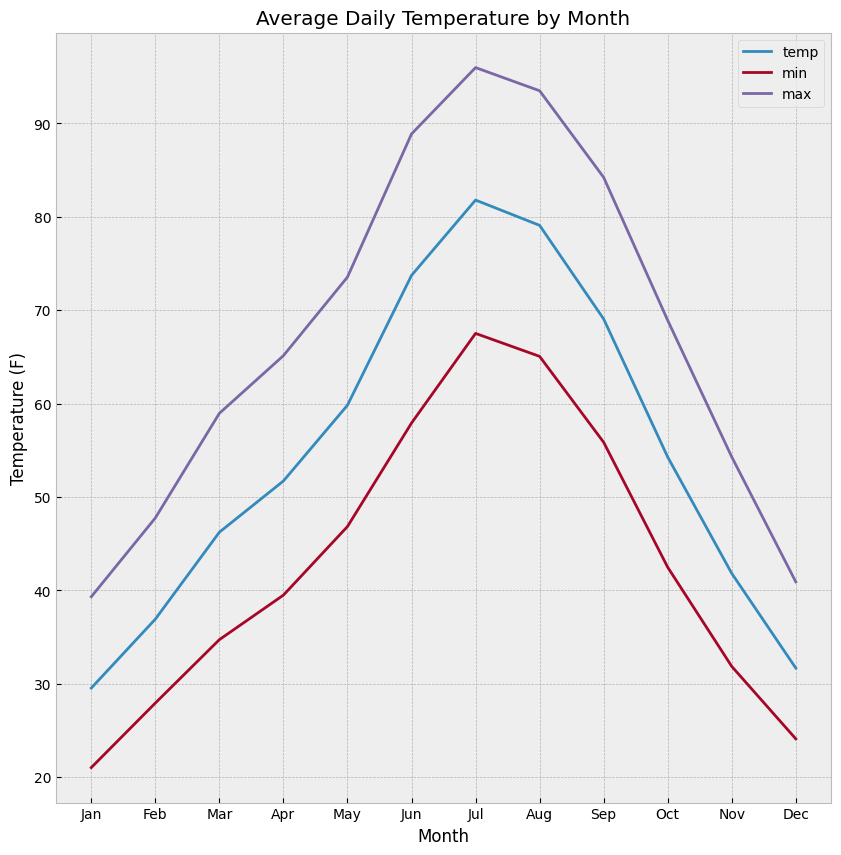

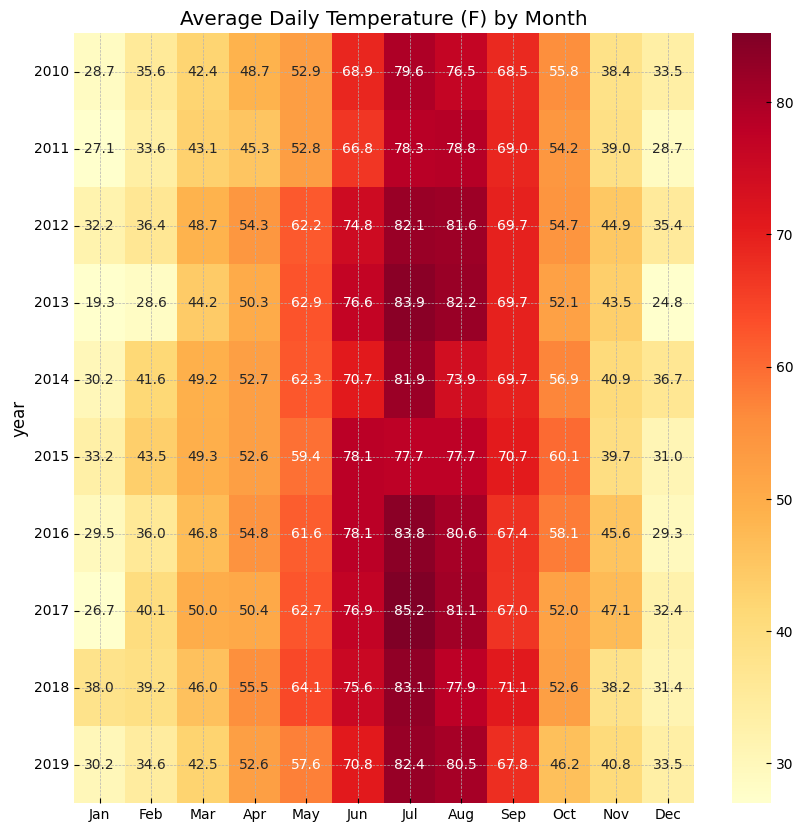

In [ ]:
print("SALT LAKE CITY INTERNATIONAL"+' :\n')
displayTemperaturePlots(SLCWeather)

#### In the city the average daily temperatures mostly stay between 20F and 95F.

BRYCE CANYON AIRPORT :



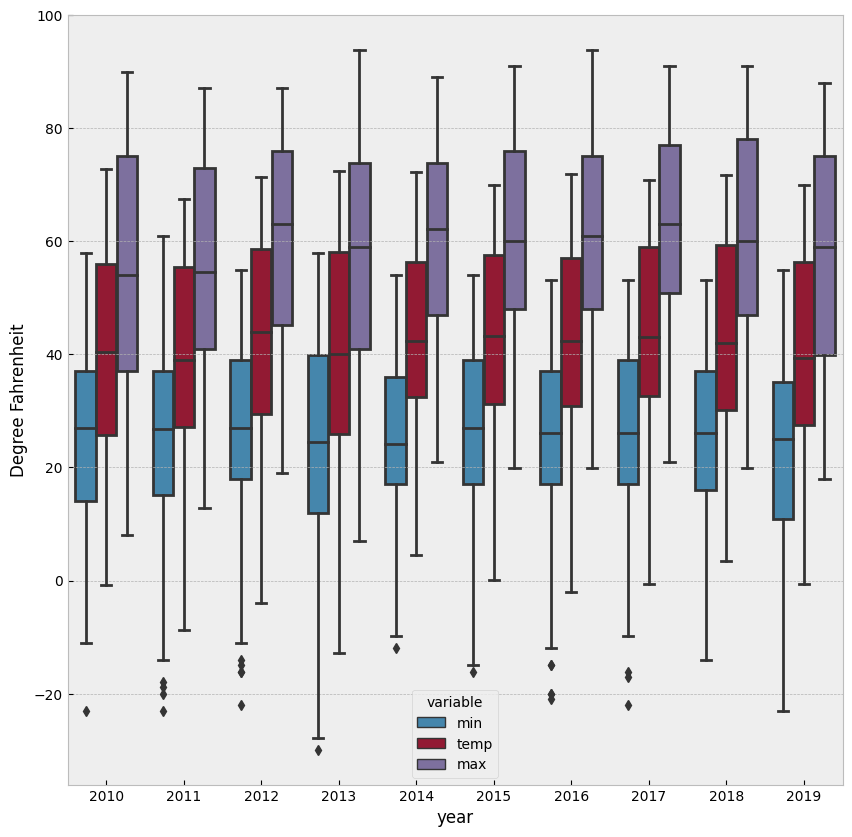

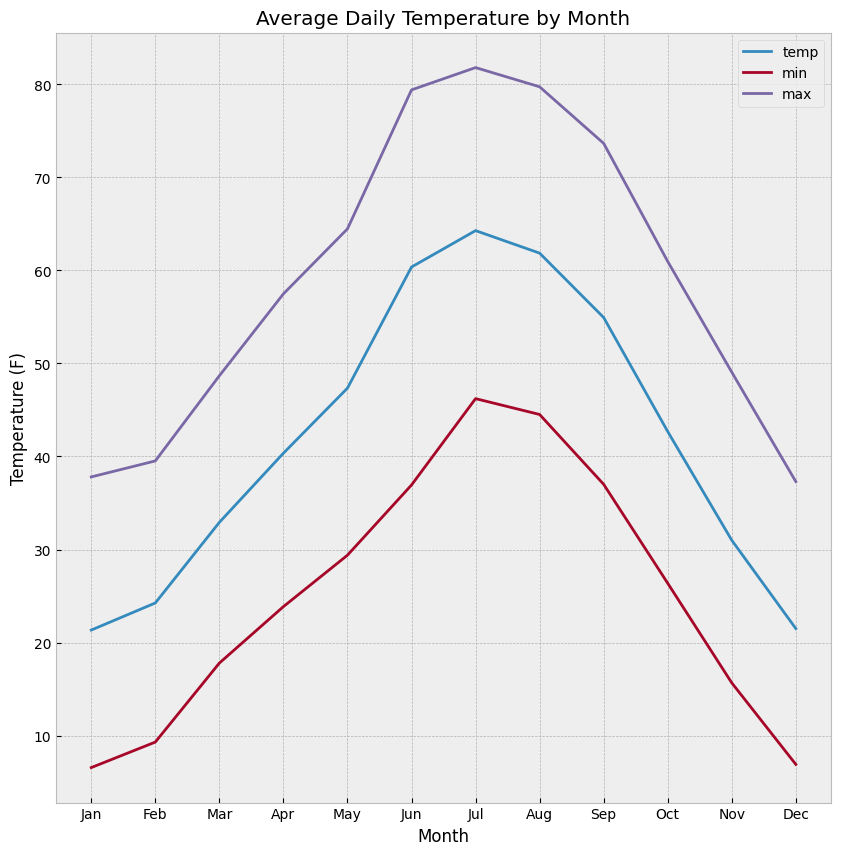

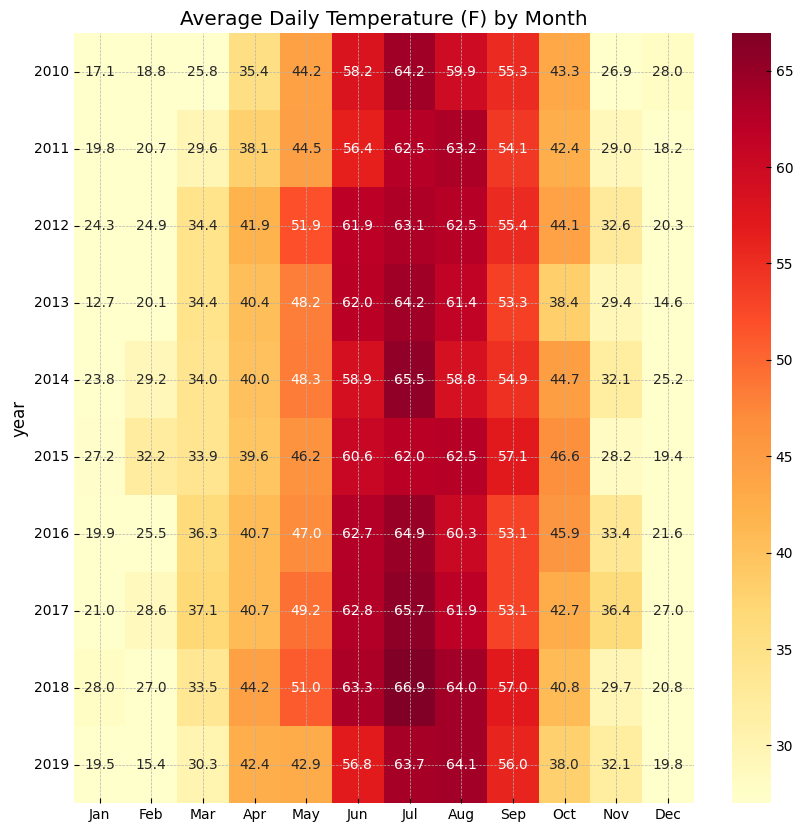

In [ ]:
print("BRYCE CANYON AIRPORT"+' :\n')
displayTemperaturePlots(mountainWeather)

#### In the mountains the daily temperatures mostly stay between 5F and 85F.

## Step 6: Plot various stations in Utah

In [ ]:
plotPointsOnMap(ut_only,0,500,'lat',lat,'lon',lon,5)

#### The above diagram shows the different stations in Utah.

In [ ]:
# Install PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=56dd9eb9aaca09f854c08910d4fb49b8046639b81b2c17c88c45bcf13314c9af
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# Install FindSpark
!pip install findspark

In [ ]:
# Implementation of pipeline and grid search using Spark

from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, dayofmonth

In [ ]:
# Create Spark Session
#Create a Spark Session named 'spark-weather-data'
spark = SparkSession.builder.appName('spark-weather-data').getOrCreate()
print('Spark Version: {}'.format(spark.version))

Spark Version: 3.5.0


In [ ]:
#Current working Mountain_dataset is a Pandas Dataframe
#which needs to be converted to PySpark Dataframe
print(type(cleanMountainWeather))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
#Create a Spark Dataframe for Mountain Weather dataset
sp1_mountain_weather = spark.createDataFrame(cleanMountainWeather)

In [ ]:
#Display the 1st 10 rows of the Mountain Weather Dataframe
sp1_mountain_weather.show(10)

+-------------------+--------+--------+--------+
|               Date|Avg Temp|Min Temp|Max Temp|
+-------------------+--------+--------+--------+
|2010-01-22 00:00:00|    25.1|    18.0|    27.0|
|2010-12-23 00:00:00|    32.2|    30.0|    36.0|
|2010-10-07 00:00:00|    45.7|    39.9|    55.0|
|2010-01-29 00:00:00|    22.5|    16.0|    32.0|
|2010-10-19 00:00:00|    43.5|    33.1|    57.9|
|2010-02-02 00:00:00|    13.2|    -2.0|    28.9|
|2010-11-22 00:00:00|    15.2|    -9.0|    27.0|
|2010-01-07 00:00:00|    26.9|    14.0|    37.9|
|2010-07-09 00:00:00|    62.2|    48.0|    79.0|
|2010-02-23 00:00:00|     7.2|   -11.0|    30.9|
+-------------------+--------+--------+--------+
only showing top 10 rows



In [ ]:
#Check the schema
sp1_mountain_weather.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Avg Temp: double (nullable = true)
 |-- Min Temp: double (nullable = true)
 |-- Max Temp: double (nullable = true)



In [ ]:
# Extracting timestamp format
sp1_mountain_weather = sp1_mountain_weather.withColumn("Year", year(sp1_mountain_weather["Date"]))
sp1_mountain_weather = sp1_mountain_weather.withColumn("Month", month(sp1_mountain_weather["Date"]))
sp1_mountain_weather = sp1_mountain_weather.withColumn("DayOfMonth", dayofmonth(sp1_mountain_weather["Date"]))
sp1_mountain_weather = sp1_mountain_weather.drop('Date')

In [ ]:
# Drop rows with any missing values
mountain1_clean = sp1_mountain_weather.na.drop()
# Drop duplicates
mountain1_clean = mountain1_clean.dropDuplicates()

In [ ]:
# First, assemble the features into a vector
assembler = VectorAssembler(inputCols=
        ["Year", "Month", "DayOfMonth", "Min Temp", "Max Temp"], outputCol="features_vec2")

In [ ]:
# Standardize features
scaler = StandardScaler(inputCol="features_vec2", outputCol="scaledFeatures2", withStd=True, withMean=False)

In [ ]:
# Split the data
(train_data3, test_data3) = mountain1_clean.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Initialize Regression Models
lr_1 = LinearRegression(featuresCol="scaledFeatures2", labelCol="Avg Temp")
rf = RandomForestRegressor(featuresCol="scaledFeatures2", labelCol="Avg Temp")
gbt = GBTRegressor(featuresCol="scaledFeatures2", labelCol="Avg Temp")

In [ ]:
# Creating Pipelines
lr_pipeline = Pipeline(stages=[assembler, scaler, lr_1])
rf_pipeline = Pipeline(stages=[assembler, scaler, rf])
gbt_pipeline = Pipeline(stages=[assembler, scaler, gbt])

In [ ]:
# Define parameter grids
param_grid_rf = (ParamGridBuilder()
                 .addGrid(RandomForestRegressor.numTrees, [50, 100, 150])
                 .addGrid(RandomForestRegressor.maxDepth, [3, 5, 7])
                 .build())

param_grid_gbt = (ParamGridBuilder()
                  .addGrid(GBTRegressor.maxIter, [10, 20, 30])
                  .addGrid(GBTRegressor.maxDepth, [3, 5, 7])
                  .build())

In [ ]:
# Create evaluator
target_column = 'Avg Temp'
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol='prediction', metricName='r2')

In [ ]:
# Perform grid search for each pipeline
rf_cv = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=param_grid_rf, evaluator=evaluator, numFolds=5)
gbt_cv = CrossValidator(estimator=gbt_pipeline, estimatorParamMaps=param_grid_gbt, evaluator=evaluator, numFolds=5)

In [ ]:
# Fit the lr model
lr_model = lr_pipeline.fit(train_data3)

23/12/14 22:49:14 WARN Instrumentation: [42104b01] regParam is zero, which might cause numerical instability and overfitting.
23/12/14 22:49:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/14 22:49:15 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [ ]:
# Fit the rf model
rf_model = rf_cv.fit(train_data3)

In [ ]:
# Fit the gbt model
gbt_model = gbt_cv.fit(train_data3)

In [ ]:
# Get best models and print results
rf_best_model = rf_model.bestModel
gbt_best_model = gbt_model.bestModel

In [ ]:
print("Linear Regression:")
print("Test set score: {:.2f}".format(evaluator.evaluate(lr_model.transform(test_data3))))

Linear Regression:
Test set score: 0.98


In [ ]:
print("Random Forest:")
print("Test set score: {:.2f}".format(evaluator.evaluate(rf_best_model.transform(test_data3))))
print("Best parameters: {}".format(rf_best_model.stages[-1]))

Random Forest:
Test set score: 0.97
Best parameters: RandomForestRegressionModel: uid=RandomForestRegressor_eea8294aa012, numTrees=20, numFeatures=5


In [ ]:
print("Gradient Boosting:")
print("Test set score: {:.2f}".format(evaluator.evaluate(gbt_best_model.transform(test_data3))))
print("Best parameters: {}".format(gbt_best_model.stages[-1]))

Gradient Boosting:
Test set score: 0.98
Best parameters: GBTRegressionModel: uid=GBTRegressor_9dcd8a8cf45b, numTrees=20, numFeatures=5


In [ ]:
# Evaluation of different models
def evaluate_reg_model(model, test_data):
    evaluator = RegressionEvaluator(labelCol="Avg Temp", predictionCol="prediction")
    model_name = model.__class__.__name__

    print("-" * 70)
    print(model_name.center(70, '-'))

    # Make predictions on the test data
    predictions = model.transform(test_data3)

    # Evaluate the model
    r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
    mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
    rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
    mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})

    print("For Mountain Weather Data:")
    print(f'R2: {r2}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print("-" * 70)
    return (r2, mse, rmse, mae)

In [ ]:
# Evaluation of lr
lr_r2, lr_mse, lr_rmse, lr_mae = evaluate_reg_model(lr_model, test_data3)

----------------------------------------------------------------------
----------------------------PipelineModel-----------------------------
For Mountain Weather Data:
R2: 0.9779217856303615
MSE: 6.041322137462781
RMSE: 2.457910115822542
MAE: 1.877220056933271
----------------------------------------------------------------------


In [ ]:
# Evaluation of rf
rf_r2, rf_mse, rf_rmse, rf_mae = evaluate_reg_model(rf_best_model, test_data3)

----------------------------------------------------------------------
----------------------------PipelineModel-----------------------------
For Mountain Weather Data:
R2: 0.9673510979286374
MSE: 8.933808302849936
RMSE: 2.9889476915546607
MAE: 2.253012766215188
----------------------------------------------------------------------


In [ ]:
# Evaluation of gbt
gbt_r2, gbt_mse, gbt_rmse, gbt_mae = evaluate_reg_model(gbt_best_model, test_data3)

----------------------------------------------------------------------
----------------------------PipelineModel-----------------------------
For Mountain Weather Data:
R2: 0.9754311829703565
MSE: 6.722832550107532
RMSE: 2.5928425617664357
MAE: 1.987716645356797
----------------------------------------------------------------------


In [ ]:
# Exploratory Data Analysis
data = {
    'Model': ['Linear Regression','Random Forest', 'Gradient Boosting'],
    'R2': [lr_r2, rf_r2, gbt_r2],
    'MSE': [lr_mse, rf_mse, gbt_mse],
    'RMSE': [lr_rmse, rf_rmse, gbt_rmse],
    'MAE': [lr_mae, rf_mae, gbt_mae],
}

pd.DataFrame(data)

,Model,R2,MSE,RMSE,MAE
0,Linear Regression,0.977922,6.041322,2.457910,1.877220
1,Random Forest,0.967351,8.933808,2.988948,2.253013
2,Gradient Boosting,0.975431,6.722833,2.592843,1.987717


**Credit:**
* Some functions for mapping and plotting were adapted from https://www.kaggle.com/anhuang/visualization-of-global-climatic-change, https://www.kaggle.com/dejavu23/openaq-from-queries-to-world-maps, and https://www.kaggle.com/tanatiem/eda-bangkok-weather.  See comments in code cells for more detail.